In [128]:
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15,8)})

path_to_catalog=r'C:\Users\kgrzebien\Desktop\python_tasks\kupony\magazynierzy\\'


In [96]:
def func_name_workers_filia(list_of_workers,
                            name_of_file_with_workers):
    
    df=pd.read_excel(name_of_file_with_workers)
    df=df.rename(columns={'PELNANAZWA':'pracownik_nazwisko',
                         'NUMER':'KOD_OPER'})
    for i in df.index:
        if df.loc[i, 'pracownik_nazwisko'].split(' ')>1:
            if df.loc[i, 'pracownik_nazwisko'].split(' ')[1] in ['PAWEŁ', 'MICHAŁ']:
                df.loc[i, 'pracownik_nazwisko']=df.loc[i, 'pracownik_nazwisko'].split(' ')[1]+' '+df.loc[i, 'pracownik_nazwisko'].split(' ')[0]
            else: continue
        else: continue
    df['pracownik_nazwisko_cut']=df['pracownik_nazwisko'].apply(lambda x: x.split(' ')[0][0]+'. '+x.split(' ')[1] if len(x.split(' '))>1 else x)
    
    if type(list_of_workers[0])==type(0):
        df=df.loc[df['pracownik_nazwisko'].isin(list_of_workers)]
    else:
        df=df.loc[df['KOD_OPER'].isin(list_of_workers)]
    return df.reset_index().drop('index', axis=1)


def func_name_of_working_magaz(name_of_file_with_workers):
    df=pd.read_excel('../magazynierzy/'+name_of_file_with_workers+'.xlsx')
    df=df[['Lista magazynierów KUPONY']]
    df=df.rename(columns={'Lista magazynierów KUPONY':'pracownik_nazwisko'})
    df['pracownik_nazwisko']=df['pracownik_nazwisko'].str.upper()
    df['pracownik_nazwisko']=df['pracownik_nazwisko'].apply(lambda x: x.split(' ')[1][0]+'. '+x.split(' ')[0] if len(x.split(' '))>1 else x)
    return df['pracownik_nazwisko'].unique()
    
    
def func_kod_magaz_oper(list_of_workers):
    df=pd.read_csv('../../słowniki/ZBMAGAZ.csv',encoding='Cp1250',
              sep="|")
    df=df.loc[df['IS_DELETED']=='N'].loc[df['KOD_MAGAZ'].isin(list_of_workers)].loc[df['KOD_MAGAZ']!=0][['KOD_MAGAZ','NAZW_IMIE','KOD_OPER']]
    df=df.sort_values(by='KOD_MAGAZ').reset_index().drop('index', axis=1)
    df=df.rename(columns={'NAZW_IMIE':'pracownik_nazwisko'})
    for i in df.index:
        if len(df.loc[i, 'pracownik_nazwisko'].split(' '))>1:
            if df.loc[i, 'pracownik_nazwisko'] in ['ŻUKOWSKI MICHAŁ', 'MIKOCIAK PAWEŁ']:
                df.loc[i, 'pracownik_nazwisko']=df.loc[i, 'pracownik_nazwisko'].split(' ')[1]+' '+df.loc[i, 'pracownik_nazwisko'].split(' ')[0]
            else: continue
        else: continue
    df['pracownik_nazwisko']=df['pracownik_nazwisko'].apply(lambda x: x.split(' ')[0][0]+'. '+x.split(' ')[1] if len(x.split(' '))>1 else x)
    return df

In [3]:
def func_read_data(path, jaki_dokument):
    df=pd.read_csv('../magazynierzy/'+path+'.csv',
              encoding='Cp1250',
              sep="|")
    df['jaki_doument']=jaki_dokument
    return df

def func_add_time(df):
    
    # df['date_start']=df['Z_DNIA']+' '+df['CZAS_POCZ_1']
    # df['date_start']=pd.to_datetime(df['date_start'], format='%y/%m/%d %H:%M:%S')
    # df['date_start']=df['date_start'].dt.floor('Min')
    # df['date_finish']=df['Z_DNIA']+' '+df['CZAS_KON_1']
    # df['date_finish']=pd.to_datetime(df['date_finish'], format='%y/%m/%d %H:%M:%S')
    # df['date_finish']=df['date_finish'].dt.floor('Min')
    df['Z_DNIA']=pd.to_datetime(df['Z_DNIA'], format='%y/%m/%d')
    
    df['year']=df['Z_DNIA'].apply(lambda x: x.year)
    df['month']=df['Z_DNIA'].apply(lambda x: x.month)
    df['day_of_year']=df['Z_DNIA'].apply(lambda x: x.timetuple().tm_yday)
    df['week']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[1])
    df['week_day']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[2])
    df['year_month']=df['year'].astype(str)+'-'+df['month'].astype(str)+'-'+'01'
    df['year_month']=df['year_month'].apply(lambda x: x[:5]+'0'+x[5:] if len(x)==9 else x)
    df['year_month']=pd.to_datetime(df['year_month'], format='%Y-%m-%d')
    df['year_week']=df['year'].astype(str)+'--'+df['week'].astype(str)
    df['year_week']=df['year_week'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)==7 else x)
    df['year_day']=df['year'].astype(str)+'--'+df['day_of_year'].astype(str)
    df['year_day']=df['year_day'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)<9 else x)
    return df

In [69]:
arr_working_magaz

array(['D. CIEŚLAWSKI', 'K. GRZYBOWSKI', 'G. HOWANIEC', 'A. KASTELIK',
       'P. MIKOCIAK', 'M. MIESZCZAK', 'K. OŻGA', 'M. PROCHOWNIK',
       'M. PTAK', 'P. PUCHACZ', 'M. ŻYKOWSKI'], dtype=object)

In [101]:
arr_working_magaz=func_name_of_working_magaz('Lista magazynierów_Kupony_19.07.22')

In [102]:
%%time
df_lkw=func_read_data('LKW', 'LKW')
df_f60lkw=func_read_data('F60LKW', 'F60LKW')
df_f60lkr=func_read_data('F60LKR', 'F60LKR')
#df_f60lkp=func_read_data('dokumenty_F60LKP', 'F60LKP')

df_lkw=func_add_time(df_lkw)
df_f60lkw=func_add_time(df_f60lkw)
df_f60lkr=func_add_time(df_f60lkr)

CPU times: total: 32.9 s
Wall time: 33 s


In [103]:
df_magaz_oper_lkw=func_kod_magaz_oper(df_lkw['KOD_MAGAZ_2'].unique())
df_magaz_oper_f60lkw=func_kod_magaz_oper(df_f60lkw['KOD_MAGAZ_2'].unique())
df_magaz_oper_f60lkr=func_kod_magaz_oper(df_f60lkr['KOD_MAGAZ_2'].unique())

In [104]:

def func_pivot_table(df, year1, year2, month, kod_dokumentu):
    df_table_pivot=pd.DataFrame(columns=['MAGAZYNIER_NAZWISKO','month',
                                         'LICZBA_POZYCJI_'+str(year1),'LICZBA_POZYCJI_'+str(year2), 'LICZBA_POZYCJI_DYNAMIKA',
                                        'kod_dokumentu'])
    
    df=df.loc[df['KOD_MAGAZ_2']!=0]
    df=df.groupby(['KOD_MAGAZ_2','year','month']).agg({'NR_DOKUM':'count'}).reset_index()
    df=df.merge(func_kod_magaz_oper(df_lkw['KOD_MAGAZ_2'].unique()),
              how='left',
              left_on='KOD_MAGAZ_2',
             right_on='KOD_MAGAZ')       
    
    for magazynier in tqdm(df['pracownik_nazwisko'].unique()):
        for mc in month:
            try:
                val1=df.loc[df['year']==year1].loc[df['month']==mc].loc[df['pracownik_nazwisko']==magazynier]['NR_DOKUM'].values[0]
            except:
                val1=0
            try:
                val2=df.loc[df['year']==year2].loc[df['month']==mc].loc[df['pracownik_nazwisko']==magazynier]['NR_DOKUM'].values[0]
            except:
                val2=0
            try:
                val_dyn=round((val2-val1)/val1, 2)
            except:
                val_dyn=0

            df_table_pivot=df_table_pivot.append({'MAGAZYNIER_NAZWISKO':magazynier,
                                                   'month':mc,
                                                    'LICZBA_POZYCJI_'+str(year1):val1,
                                                    'LICZBA_POZYCJI_'+str(year2):val2, 
                                                    'LICZBA_POZYCJI_DYNAMIKA':val_dyn,
                                                 'kod_dokumentu':kod_dokumentu},
                                                ignore_index=True)
                
                
                
        df_table_pivot=df_table_pivot.fillna(0)
        df_table_pivot.replace([np.inf, -np.inf], 0, inplace=True)
        
        val1=df_table_pivot.loc[df_table_pivot['MAGAZYNIER_NAZWISKO']==magazynier]['LICZBA_POZYCJI_'+str(year1)].sum()
        val2=df_table_pivot.loc[df_table_pivot['MAGAZYNIER_NAZWISKO']==magazynier]['LICZBA_POZYCJI_'+str(year2)].sum()
        try:
            val_dyn=(val2-val1)/val1#*100
            val_dyn=round(val_dyn, 2)
        except:
            val_dyn=0
            
        df_table_pivot=df_table_pivot.append({'MAGAZYNIER_NAZWISKO':magazynier,
                                               'month':'suma',
                                                'LICZBA_POZYCJI_'+str(year1):val1,
                                                'LICZBA_POZYCJI_'+str(year2):val2, 
                                                'LICZBA_POZYCJI_DYNAMIKA':val_dyn,
                                             'kod_dokumentu':kod_dokumentu},
                                                ignore_index=True)   
        
        
    df_table_pivot=df_table_pivot.fillna(0)
    df_table_pivot.replace([np.inf, -np.inf], 0, inplace=True)
    return df_table_pivot


def func_add_pivot_tables(arr_df, col_group, col_change_name):
    for i in range(len(arr_df)):
        for col_name in col_change_name:
            arr_df[i]=arr_df[i].rename(columns={col_name:col_name+'_'+arr_df[i]['kod_dokumentu'].values[0]})
        arr_df[i]=arr_df[i].drop('kod_dokumentu', axis=1)
            
    df_to_return=arr_df[0]
    
    for i in range(len(arr_df)-1):
        df_to_return=df_to_return.merge(arr_df[i+1], how='outer', on=col_group)
        
    df_to_return=df_to_return.fillna(0)
    return df_to_return

def func_add_col_with_sum(df, year1, year2, col_to_sum, arr_domukent):
    for col_name in col_to_sum:
        df['SUMA_'+col_name+'_'+str(year1)]=0
        df['SUMA_'+col_name+'_'+str(year2)]=0
        
    for col_name in col_to_sum:
        for dok in arr_domukent:
            df['SUMA_'+col_name+'_'+str(year1)]+=df[col_name+'_'+str(year1)+'_'+dok]
            df['SUMA_'+col_name+'_'+str(year2)]+=df[col_name+'_'+str(year2)+'_'+dok]
            
    for col_name in col_to_sum:
        df['SUMA_'+col_name+'_DYNAMIKA']=round((df['SUMA_'+col_name+'_'+str(year2)]-df['SUMA_'+col_name+'_'+str(year1)])/df['SUMA_'+col_name+'_'+str(year1)], 2)
        
    df=df.fillna(0)
    df.replace([np.inf, -np.inf], 0, inplace=True)
    return df

In [46]:
df_lkw

,NR_DOKUM,KOD_KONTR,Z_DNIA,CZAS_POCZ_1,CZAS_KON_1,NR_PZWZ,DATA_PZWZ,STATUS,KOD_OPER,KOD_MAGAZ_1,WAGA,KOD_STAN,POMYLKI,ILOSC,KOD_MAGAZ_2,CZAS_POCZ_2,CZAS_KON_2,KOD_NAKL,jaki_doument,year,month,day_of_year,week,week_day,year_month,year_week,year_day
0,LW20/418,60XXXX,2020-01-02,14:17:50,14:30:30,WZ0000535991,20/01/02,Z,1683,670,"47,14",1,0,"24,9",670,14:26:15,14:26:36,2210006156757,LKW,2020,1,2,1,4,2020-01-01,2020--01,2020--02
1,LW20/418,60XXXX,2020-01-02,14:17:50,14:30:30,WZ0000535991,20/01/02,Z,1683,670,"47,14",1,0,1,0,,,2210006156757,LKW,2020,1,2,1,4,2020-01-01,2020--01,2020--02
2,LW20/419,60XXXX,2020-01-02,14:17:55,14:21:46,WZ0000535992,20/01/02,Z,1683,670,"26,01",1,0,"20,5",670,14:19:27,14:20:26,2210006156740,LKW,2020,1,2,1,4,2020-01-01,2020--01,2020--02
3,LW20/419,60XXXX,2020-01-02,14:17:55,14:21:46,WZ0000535992,20/01/02,Z,1683,670,"26,01",1,0,"26,5",670,14:20:26,14:21:05,2210006156740,LKW,2020,1,2,1,4,2020-01-01,2020--01,2020--02
4,LW20/419,60XXXX,2020-01-02,14:17:55,14:21:46,WZ0000535992,20/01/02,Z,1683,670,"26,01",1,0,"23,3",670,14:19:09,14:19:27,2210006156740,LKW,2020,1,2,1,4,2020-01-01,2020--01,2020--02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86178,LW22/205533,60XXXX,2022-07-21,06:00:59,06:17:31,WZ0001499763,22/07/21,Z,2053,682,"18,69",1,0,20,682,06:10:51,06:11:08,2210016806406,LKW,2022,7,202,29,4,2022-07-01,2022--29,2022--202
86179,LW22/205533,60XXXX,2022-07-21,06:00:59,06:17:31,WZ0001499763,22/07/21,Z,2053,682,"18,69",1,0,1,0,,,2210016806406,LKW,2022,7,202,29,4,2022-07-01,2022--29,2022--202
86180,LW22/205959,60XXXX,2022-07-21,12:21:40,12:24:10,WZ0001500171,22/07/21,Z,896,499,0,1,0,1,0,,,2210016814319,LKW,2022,7,202,29,4,2022-07-01,2022--29,2022--202
86181,LW22/205959,60XXXX,2022-07-21,12:21:40,12:24:10,WZ0001500171,22/07/21,Z,896,499,0,1,0,24,499,12:23:42,12:23:47,2210016814319,LKW,2022,7,202,29,4,2022-07-01,2022--29,2022--202


In [105]:
df_lkw_pivot=func_pivot_table(df_lkw, 2021, 2022, [1,2,3,4,5,6], 'LKW')
df_lkw_pivot=df_lkw_pivot.loc[df_lkw_pivot['MAGAZYNIER_NAZWISKO'].isin(df_lkw_pivot.loc[df_lkw_pivot['month']=='suma'].\
                                                                       loc[(df_lkw_pivot['LICZBA_POZYCJI_2021']!=0) |\
                                                                           (df_lkw_pivot['LICZBA_POZYCJI_2022']!=0)]['MAGAZYNIER_NAZWISKO'].unique())]

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:17<00:00,  3.67it/s]


In [106]:
df_f60lkw_pivot=func_pivot_table(df_f60lkw, 2021, 2022, [1,2,3,4,5,6], 'F60LKW')
df_f60lkw_pivot=df_f60lkw_pivot.loc[df_f60lkw_pivot['MAGAZYNIER_NAZWISKO'].isin(df_f60lkw_pivot.loc[df_f60lkw_pivot['month']=='suma'].\
                                                                                                   loc[(df_f60lkw_pivot['LICZBA_POZYCJI_2021']!=0) |\
                                                                                                       (df_f60lkw_pivot['LICZBA_POZYCJI_2022']!=0)]['MAGAZYNIER_NAZWISKO'].unique())]

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.79it/s]


In [107]:
df_f60lkr_pivot=func_pivot_table(df_f60lkr, 2021, 2022, [1,2,3,4,5,6], 'F60LKR')
df_f60lkr_pivot=df_f60lkr_pivot.loc[df_f60lkr_pivot['MAGAZYNIER_NAZWISKO'].isin(df_f60lkr_pivot.loc[df_f60lkr_pivot['month']=='suma'].\
                                                                                                   loc[(df_f60lkr_pivot['LICZBA_POZYCJI_2021']!=0) |\
                                                                                                       (df_f60lkr_pivot['LICZBA_POZYCJI_2022']!=0)]['MAGAZYNIER_NAZWISKO'].unique())]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.67it/s]


In [108]:
df_pivot=func_add_pivot_tables([df_lkw_pivot, df_f60lkw_pivot, df_f60lkr_pivot],
                              ['MAGAZYNIER_NAZWISKO','month'],
                              ['LICZBA_POZYCJI_2021','LICZBA_POZYCJI_2022','LICZBA_POZYCJI_DYNAMIKA'])
df_pivot=func_add_col_with_sum(df_pivot, 2021, 2022,
                              ['LICZBA_POZYCJI'],
                              ['LKW', 'F60LKW', 'F60LKR'])
df_pivot=df_pivot.loc[df_pivot['MAGAZYNIER_NAZWISKO'].isin(arr_working_magaz)]

In [109]:
df_pivot.to_excel(path_to_catalog+'df_pivot_magazynierzy_lkw_f60lkw_f60lkr.xlsx')

In [124]:
df1=df_lkw.groupby(['KOD_MAGAZ_2','year_month']).agg({'NR_DOKUM':'count'}).reset_index()
df2=df_f60lkw.groupby(['KOD_MAGAZ_2','year_month']).agg({'NR_DOKUM':'count'}).reset_index()
df3=df_f60lkr.groupby(['KOD_MAGAZ_2','year_month']).agg({'NR_DOKUM':'count'}).reset_index()

df1=pd.concat([df1, df2]).groupby(['KOD_MAGAZ_2','year_month']).sum().reset_index()
df1=pd.concat([df1, df3]).groupby(['KOD_MAGAZ_2','year_month']).sum().reset_index()

df1=df1.merge(func_kod_magaz_oper(df_lkw['KOD_MAGAZ_2'].unique()),
              how='left',
              left_on='KOD_MAGAZ_2',
             right_on='KOD_MAGAZ')  
df1=df1[['year_month','NR_DOKUM','pracownik_nazwisko']]
df1=df1.loc[df1['pracownik_nazwisko'].isin(arr_working_magaz)]

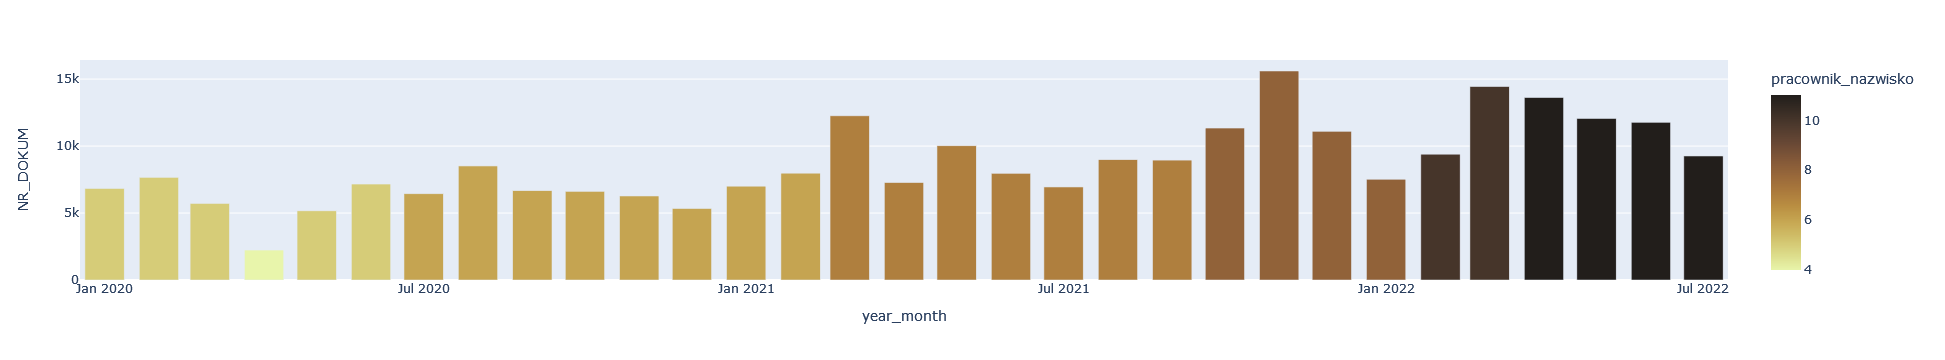

In [140]:
px.bar(df1.groupby('year_month').agg({'NR_DOKUM':'sum',
                                      'pracownik_nazwisko':'nunique'}).reset_index(),
        x='year_month',
        y='NR_DOKUM',
        color='pracownik_nazwisko',
      color_continuous_scale='turbid')